In [1]:
from os.path import expandvars

import numpy as np
from astropy import units as u

import matplotlib.pyplot as plt
%matplotlib inline

from ctapipe.utils import linalg

from ctapipe.io.hessio import hessio_event_source
from ctapipe.instrument.camera import CameraGeometry

from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.hillas import hillas_parameters_4 as hillas_parameters


# does the calibration from ADC to pe
from ctapipe.calib import CameraCalibrator
calib = CameraCalibrator(None, None)


# does the shower reconstruction
from ctapipe.reco.HillasReconstructor import HillasReconstructor
reco = HillasReconstructor()


# missing in event.inst so keeping track of it separately
tel_phi = {}
tel_theta = {}
tel_orientation = (tel_phi, tel_theta)


# load a file and create an event generator
filename = expandvars("$HOME/Data/cta/ASTRI9/gamma/run1001.simtel.gz")
source = hessio_event_source(filename, allowed_tels=range(10), max_events=500)

In [2]:
off_angles = []

# loop over all loaded events
for event in source:
    
    # CameraCalibrator calibrates all telescopes in the event at once
    calib.calibrate(event)

    # dictionary for the hillas parameters of this event
    hillas_dict = {}
    
    # the direction the parent particle is coming from 
    source_orig = linalg.set_phi_theta(event.mc.az,
                                       (np.pi*u.rad/2-event.mc.alt))

    # loop over all telescopes in this event
    for tel_id in event.dl0.tels_with_data:

        cam_geom = CameraGeometry.guess(event.inst.pixel_pos[tel_id][0],
                                        event.inst.pixel_pos[tel_id][1],
                                        event.inst.optical_foclen[tel_id])
        if tel_id not in tel_phi:
            tel_phi[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
            tel_theta[tel_id] = (np.pi/2-event.mc.tel[tel_id].altitude_raw)*u.rad

        
        # some cameras have more than one gain channel,
        # need to pick one with the [0] at the end
        pmt_signal = event.dl1.tel[tel_id].image[0]


        # tailcut cleaning
        
        # make a copy first
        cleaned_image = pmt_signal[:]

        # create a mask of pixels we want to keep
        mask = tailcuts_clean(cam_geom, pmt_signal,
                          picture_thresh=10,
                          boundary_thresh=5)

        # set all rejected pixels to zero
        cleaned_image[~mask] = 0


        # hillas parametrisation
        try:
            hillas_dict[tel_id] = hillas_parameters(cam_geom.pix_x,
                                                    cam_geom.pix_y,
                                                    cleaned_image)
        except:
            pass
    
    # reconstruction needs at least two telescopes
    if len(hillas_dict) < 2:
        continue
    
    # telescope loop done, now do the core fit
    reco.get_great_circles(hillas_dict,
                           event.inst,
                           *tel_orientation)

    # position fit with error estimator
    # pos_fit, err_est_pos = reco.fit_core_crosses()

    # fit the gamma's direction of origin
    fit_dir, _ = reco.fit_origin_crosses()

    # sometimes fit fails for some reason
    if np.isnan(fit_dir).any(): continue
    
    # get angular offset between reconstructed direction and MC generated direction
    off_angle = linalg.angle(fit_dir, source_orig)

    # ... and put them in a list
    off_angles.append(off_angle.to(u.deg).value)

/home/ichanmich/software/anaconda3/lib/python3.6/site-packages/ctapipe-5-py3.6.egg/ctapipe/image/hillas.py:691: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)
/home/ichanmich/software/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/ichanmich/software/anaconda3/lib/python3.6/site-packages/ctapipe-5-py3.6.egg/ctapipe/utils/linalg.py:71: RuntimeWarning: invalid value encountered in true_divide
  return vec / length(vec)


# plot the angular errors

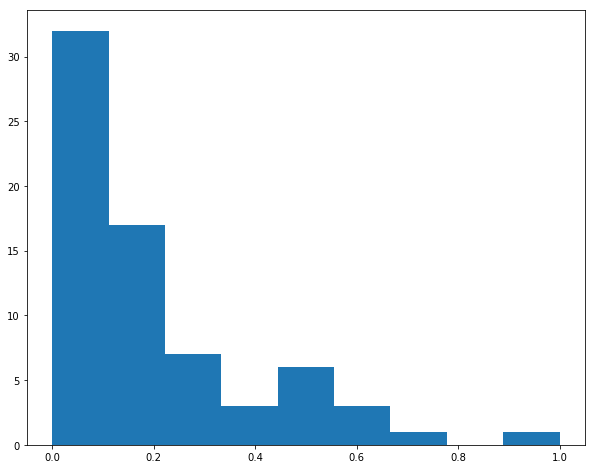

In [4]:
plt.figure(figsize=(10,8))
_ = plt.hist(off_angles, bins=np.linspace(0,1,10))